#### Notebook Analyzing a Battery Cell

#### Notebook of work for a small project
#### Analyzed some test data from a LFP cell, fit a 2-RC model and perform a simple simulation of the voltage response based on the current

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### [1] Load the test and validation data and explore the data, calculate DCIR impedance values and the SoC curve

In [52]:
#import the characterization file 1
import os
os.getcwd()
df = pd.read_csv('_data/characterisation_1.txt', delimiter='\t')
df = df.apply(pd.to_numeric, errors='coerce')

#check the headers
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18984 entries, 0 to 18983
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time_s            18984 non-null  float64
 1   voltage_V         18984 non-null  float64
 2   I_mA              18984 non-null  float64
 3   Capacity_mAh      18984 non-null  float64
 4   dq_mAh            18984 non-null  float64
 5   Energy_Wh         18984 non-null  float64
 6   Temperature_degC  18984 non-null  float64
 7   Ns                18984 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1.2 MB


In [53]:
#The info shows time, voltage, current, capacity, dq, energy counters as well as a temperature reading and 
#a counter called Ns which I have no specific knowledge of but looks like it controls the cycling test
df['dt']=df['time_s'].diff() #check the time intervals for acquisition rates
df['diff'] = df['Ns'].diff() #check the change in Ns control signal
df.describe()

,time_s,voltage_V,I_mA,Capacity_mAh,dq_mAh,Energy_Wh,Temperature_degC,Ns,dt,diff
count,18984.000000,18984.000000,18984.000000,18984.000000,18984.000000,18984.000000,18984.000000,18984.000000,18983.000000,18983.000000
mean,325601.084818,3.143805,27.322011,7699.329537,-0.001303,287.796064,18.579478,2.489992,30.419486,0.000527
std,83558.702369,0.141112,3845.632568,21874.814174,94.522228,97.166199,0.501905,1.498566,185.004199,0.071851
min,70718.325373,2.499973,-20194.408000,0.000000,-3557.549454,0.000000,17.681060,0.000000,0.002000,-1.000000
25%,310415.993116,3.087200,0.000000,0.094985,0.000000,276.746212,18.243374,2.000000,1.000000,0.000000
50%,315161.743611,3.095671,0.000000,0.094985,0.000000,276.746212,18.393850,2.000000,1.000000,0.000000
75%,319907.494106,3.199524,0.000000,0.109975,0.000000,276.746212,18.742327,2.000000,1.202000,0.000000
max,648171.432346,3.650080,17379.750000,89155.589583,3749.471856,585.456261,20.540142,10.000000,3600.000376,3.000000


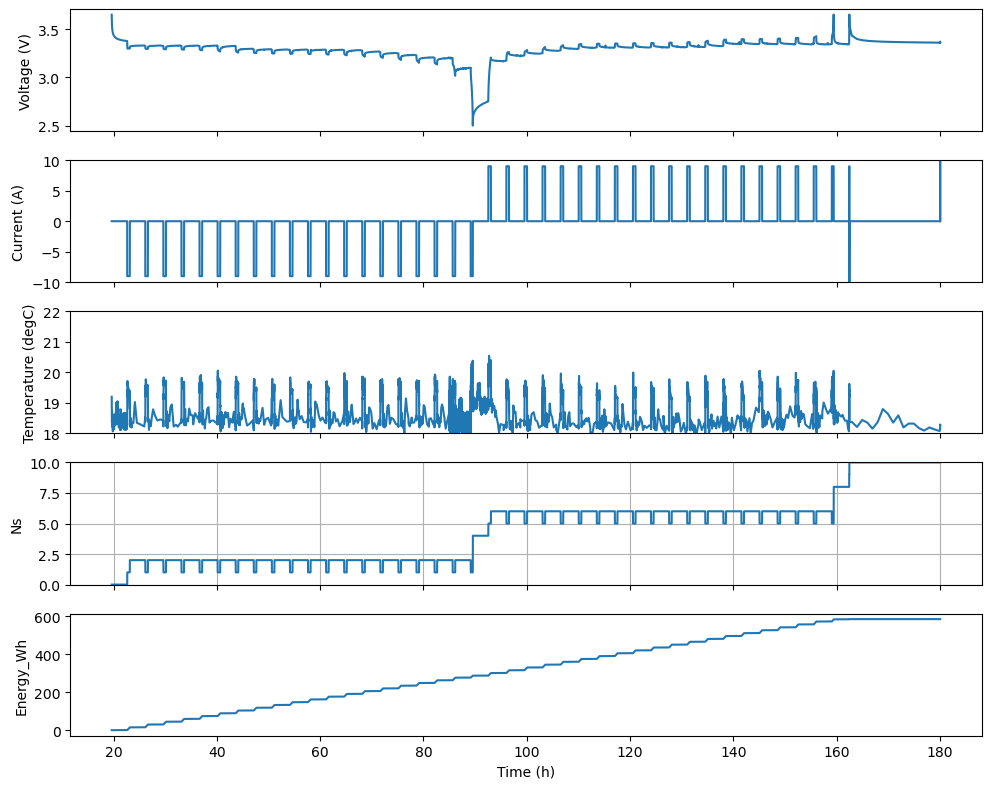

In [54]:
#basic voltage and current plot of the characterization data
#The initial voltage is 3.65V, the discharge/charge current is 
#periodically applied with rest periods (0 mA current) where the cell voltage relaxes
#The total time period is about 7.5 days
#there are a couple of large pulses at the end of the cycle that need to be understood

#the total length of the data is 18984
#The current applied is 9A
#The max voltage 3.65V, minimum about 2.5V
#The voltage profile is relatively flat at 3.2V/3.3V until the discharged state
#This looks like a LiFePO4 cell 
#The temperature is elevated at the midpoint of the cycle (with discharged cell)
#The temperature rises when loaded
#It would nice to know more about the acquisition rate of the data

fig, axs = plt.subplots(5, 1, figsize=(10, 8), sharex=True)
axs[0].plot(df['time_s']/3600, df['voltage_V']) 
axs[0].set_ylabel('Voltage (V)')
axs[1].plot(df['time_s']/3600, df['I_mA']/1000) 
axs[1].set_ylabel('Current (A)')
axs[1].set_ylim(-10, 10) 
axs[2].plot(df['time_s']/3600, df['Temperature_degC']) 
axs[2].set_ylabel('Temperature (degC)')
axs[2].set_ylim(18,22)
axs[3].plot(df['time_s']/3600, df['Ns'])
axs[3].set_ylabel('Ns')
axs[3].set_ylim(0,10)
axs[3].grid('true')
axs[4].plot(df['time_s']/3600, df['Energy_Wh'])
axs[4].set_ylabel('Energy_Wh')
axs[4].set_xlabel('Time (h)') 
#axs[4].set_xlim(70000, 650000) 

plt.tight_layout()
plt.show()


In [55]:
#Discharge Capacity where Ns = 1
state = df[df['Ns']==1]
print('Discharge Summary')
print('Total capacity on discharge measured in Wh: ', state['Energy_Wh'][15829].round(2))
print('Total capacity on discharge: ', ((-state['dq_mAh'].sum())/1000).round(2), 'Ah')
print('Total time discharging: ', ((state['dt'].sum())/60/60).round(2), ' h')
print('Mean discharge current: ', ((state['I_mA'].mean())/1000).round(2), ' A')
print('Mean discharge voltage: ', (state['voltage_V'].mean()).round(2), ' V')

Discharge Summary
Total capacity on discharge measured in Wh:  287.33
Total capacity on discharge:  89.18 Ah
Total time discharging:  9.91  h
Mean discharge current:  -9.0  A
Mean discharge voltage:  3.08  V


In [56]:
#Charge Capacity where Ns=5
state = df[df['Ns']==5]
print('Charge Summary')
print('Total capacity on charge measured in Wh: ', (state['Energy_Wh'][18619])-(df['Energy_Wh'][15829]).round(2))
print('Total capacity on charge measured in Ah: ', ((-state['dq_mAh'].sum())/1000).round(2), 'Ah')
print('Total time charging: ', ((state['dt'].sum())/60/60).round(2), ' h')
print('Mean charge current: ', ((state['I_mA'].mean())/1000).round(2), ' A')
print('Mean charge voltage: ', (state['voltage_V'].mean()).round(2), ' V')

Charge Summary
Total capacity on charge measured in Wh:  296.8528030246941
Total capacity on charge measured in Ah:  -88.79 Ah
Total time charging:  9.86  h
Mean charge current:  9.0  A
Mean charge voltage:  3.27  V


Text(0.5, 0, 'Capacity (Ah)')

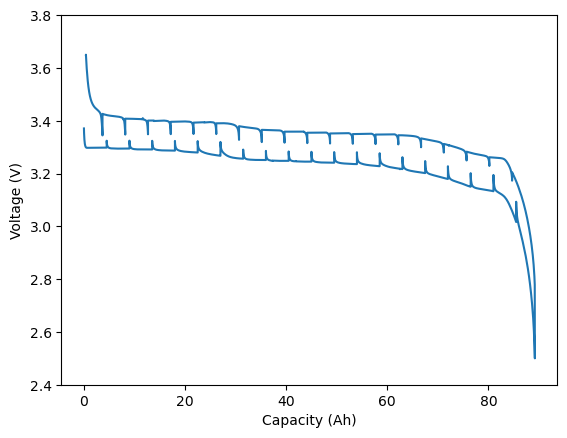

In [57]:
#Plot of the capacity while discharge/charge
#Note the difference in the capacithy measured
state = df[df['Ns'].isin([1, 5])]
state = state.copy()
plt.plot(-state['dq_mAh'].cumsum()/1000, state['voltage_V']) 
plt.ylabel('Voltage (V)')
plt.ylim(2.4,3.8)
plt.xlabel('Capacity (Ah)')
#plt.xlim(0,10)

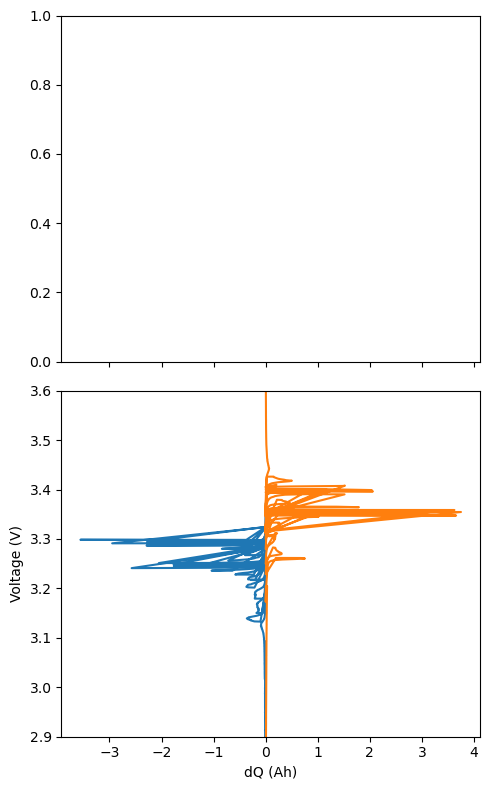

In [58]:
#Differential Capacity Plots 
#(dq/dV where dV is 1mV in the test data)
#Ns==1, Ns==5 are the discharge/charge

fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
state = df[df['Ns'].isin([1])]
axs[1].plot(state['dq_mAh']/1000, state['voltage_V']) 
state = df[df['Ns'].isin([5])]
axs[1].plot(state['dq_mAh']/1000, state['voltage_V']) 
axs[1].set_ylabel('Voltage (V)')
axs[1].set_ylim(2.9,3.6)
axs[1].set_xlabel('dQ (Ah)')
#axs[0].set_xlim(-2, 2) 

plt.tight_layout()
plt.show()


In [59]:
#function that takes a start index and time interval and prints the DCIR values

def calculate_dcir(df, pulse_start_index, time_offset):
    """
    Calculate DCIR value at a specific time after a current pulse.

    Parameters:
        df: DataFrame containing time_s, voltage_V, and I_mA columns
        pulse_start_index (int): Index where the current pulse starts
        time_offset (float): Time after pulse start (in seconds) to calculate DCIR

    Returns:
        float or None: DCIR value in Ohms, or None if ΔI = 0.
    """
    start_time = df['time_s'][pulse_start_index]
    start_voltage = df['voltage_V'][pulse_start_index]
    start_current = df['I_mA'][pulse_start_index]

    target_time = start_time + time_offset
    closest_index = (df['time_s'] - target_time).abs().idxmin()
    t_end = df['time_s'][closest_index]
    dt = t_end - df['time_s'][pulse_start_index]

    voltage = df['voltage_V'][closest_index]
    current = df['I_mA'][closest_index]

    dV = voltage - start_voltage
    dI = (current - start_current)/1000
    dcir = dV/dI
    print('OCV: ', start_voltage, ' V')
    print('start index: ', pulse_start_index )
    print('closest index: ', closest_index)
    print('dt: ', dt, ' s')
    print('dV: ', dV, ' V')
    print('dI: ', dI, ' A')
    print('DCIR: ', dcir, 'Ohm')
    print('DCIR: ', (dcir*1000).round(3), 'mOhm')

    return None


In [60]:
print('DCIR Calculations (First Pulse on Discharge, ~100% SoC\n')
print('10s')
calculate_dcir(df, 180, 10)
print('\n30s')
calculate_dcir(df, 180, 30)
print('\n60s')
calculate_dcir(df, 180, 60)

DCIR Calculations (First Pulse on Discharge, ~100% SoC

10s
OCV:  3.3709054  V
start index:  180
closest index:  199
dt:  10.38200052198954  s
dV:  -0.018950400000000034  V
dI:  -8.998138999999998  A
DCIR:  0.002106035481336756 Ohm
DCIR:  2.106 mOhm

30s
OCV:  3.3709054  V
start index:  180
closest index:  217
dt:  29.4340014802292  s
dV:  -0.03750679999999962  V
dI:  -8.999122999999999  A
DCIR:  0.0041678283539406695 Ohm
DCIR:  4.168 mOhm

60s
OCV:  3.3709054  V
start index:  180
closest index:  233
dt:  58.76800295547582  s
dV:  -0.05397509999999972  V
dI:  -8.998336  A
DCIR:  0.005998342360187452 Ohm
DCIR:  5.998 mOhm


In [61]:
print('DCIR Calculations (Index 488, OCV 3.3V) \n')

print('10s')
calculate_dcir(df, 488, 10)
print('\n30s')
calculate_dcir(df, 488, 30)
print('\n60s')
calculate_dcir(df, 488, 60)
print('\n180s')
calculate_dcir(df, 488, 180)
print('\n300s')
calculate_dcir(df, 488, 300)
print('\n500s')
calculate_dcir(df, 488, 500)


print('\nDischarge Summary and SoC')
print('Total capacity on discharge measured in Wh: ', df['Energy_Wh'][15829])
state = df[df['Ns']==1]
print('Total capacity on discharge: ', ((-state['dq_mAh'].sum())/1000), 'Ah')
print('Total capacity on discharge measured in Wh up to Index 488: ', df['Energy_Wh'][489])
print('Total capacity on discharge up to Index 488: ', ((-df['dq_mAh'][0:489].sum())/1000), 'Ah')
print('SoC ', 100-100*df['Energy_Wh'][489]/df['Energy_Wh'][15829], ' ', 100-100*((-df['dq_mAh'][0:489].sum())/1000)/((-state['dq_mAh'].sum())/1000))


DCIR Calculations (Index 488, OCV 3.3V) 

10s
OCV:  3.323628  V
start index:  488
closest index:  499
dt:  10.24000106845051  s
dV:  -0.010637599999999914  V
dI:  -8.998533  A
DCIR:  0.0011821482457195982 Ohm
DCIR:  1.182 mOhm

30s
OCV:  3.323628  V
start index:  488
closest index:  506
dt:  29.26400305260904  s
dV:  -0.017886999999999986  V
dI:  -8.997941  A
DCIR:  0.001987899231613097 Ohm
DCIR:  1.988 mOhm

60s
OCV:  3.323628  V
start index:  488
closest index:  512
dt:  60.46000630687922  s
dV:  -0.024111800000000017  V
dI:  -8.998533  A
DCIR:  0.002679525651570097 Ohm
DCIR:  2.68 mOhm

180s
OCV:  3.323628  V
start index:  488
closest index:  521
dt:  192.81002011196688  s
dV:  -0.033331  V
dI:  -8.997941  A
DCIR:  0.0037042919041145074 Ohm
DCIR:  3.704 mOhm

300s
OCV:  3.323628  V
start index:  488
closest index:  524
dt:  321.6260335482657  s
dV:  -0.036443299999999734  V
dI:  -8.998138999999998  A
DCIR:  0.004050093024790986 Ohm
DCIR:  4.05 mOhm

500s
OCV:  3.323628  V
start inde

In [62]:
#95% dcir calculation, index 281

print('DCIR Calculations (Index 281, OCV 3.3V) \n')

print('10s')
calculate_dcir(df, 281, 10)
print('\n30s')
calculate_dcir(df, 281, 30)
print('\n60s')
calculate_dcir(df, 281, 60)



print('\nDischarge Summary and SoC')
print('Total capacity on discharge measured in Wh: ', df['Energy_Wh'][15829])
state = df[df['Ns']==1]
print('Total capacity on discharge: ', ((-state['dq_mAh'].sum())/1000), 'Ah')
print('Total capacity on discharge measured in Wh up to Index 281: ', df['Energy_Wh'][282])
print('Total capacity on discharge up to Index 488: ', ((-df['dq_mAh'][0:282].sum())/1000), 'Ah')
print('SoC ', 100-100*df['Energy_Wh'][282]/df['Energy_Wh'][15829], ' ', 100-100*((-df['dq_mAh'][0:282].sum())/1000)/((-state['dq_mAh'].sum())/1000))

DCIR Calculations (Index 281, OCV 3.3V) 

10s
OCV:  3.324337  V
start index:  281
closest index:  291
dt:  10.962000551167876  s
dV:  -0.009415999999999869  V
dI:  -8.998927  A
DCIR:  0.0010463469700331906 Ohm
DCIR:  1.046 mOhm

30s
OCV:  3.324337  V
start index:  281
closest index:  297
dt:  30.994001558530726  s
dV:  -0.01560159999999966  V
dI:  -8.997745  A
DCIR:  0.0017339455608043639 Ohm
DCIR:  1.734 mOhm

60s
OCV:  3.324337  V
start index:  281
closest index:  302
dt:  64.43400324044342  s
dV:  -0.020801999999999765  V
dI:  -8.9987295  A
DCIR:  0.0023116596626223474 Ohm
DCIR:  2.312 mOhm

Discharge Summary and SoC
Total capacity on discharge measured in Wh:  287.32737139946397
Total capacity on discharge:  89.17843418918999 Ah
Total capacity on discharge measured in Wh up to Index 281:  14.84475728641927
Total capacity on discharge up to Index 488:  4.499209071996528 Ah
SoC  94.83350395261127   94.95482387316696


In [63]:
#Let's look at the data and find the index values at the cycling endpoints from 
# state=rest -> state=discharge/charge Ns=2->1 0r 6->5
change = df[df['diff'].shift(-1) == -1]
counter = pd.concat([df[0:1], change]) #include the beginning rest state Ns=0 value
counter = counter.reset_index() 

#calculate the total Ah measured for each OCV index
counter['dq_mAh_sum'] = None
for i, row in counter.iterrows():
    index = row['index']
    sum = -df['dq_mAh'][0:index].sum()/1000
    counter.at[i, 'Ah_sum'] = sum

#add in the SoC (calculated from the total discharge capacity seen in this cell)
#note that the end of discharge index is hard coded here, to generalize the code, use a variable
counter['SoC'] = 100 + 100*(counter['Ah_sum'])/(df['dq_mAh'][0:15829].sum()/1000)

counter[0:20]

,index,time_s,voltage_V,I_mA,Capacity_mAh,dq_mAh,Energy_Wh,Temperature_degC,Ns,dt,diff,dq_mAh_sum,Ah_sum,SoC
0,0,70718.325373,3.648819,0.0,0.000000,0.0,0.000000,19.201680,0,NaN,NaN,None,-0.000000,100.000000
1,281,94118.396550,3.324337,0.0,0.099984,0.0,14.844741,18.504728,2,720.134036,0.0,None,4.499209,94.954930
2,342,106718.431184,3.324613,0.0,0.099979,0.0,29.672677,18.425531,2,2046.208103,0.0,None,8.998401,89.909880
3,411,119318.469818,3.324140,0.0,0.099995,0.0,44.487222,18.465130,2,416.416021,0.0,None,13.497610,84.864811
4,488,131918.502497,3.323628,0.0,0.099984,0.0,59.286321,18.678967,2,1001.134096,0.0,None,17.996814,79.819747
5,579,144518.535811,3.323037,0.0,0.099973,0.0,74.063783,18.520569,2,87.618009,0.0,None,22.496008,74.774694
6,691,157118.573126,3.319964,0.0,0.099988,0.0,88.806794,18.401772,2,116.266012,0.0,None,26.995216,69.729626
7,792,169718.610440,3.290927,0.0,0.099977,0.0,103.500169,18.187933,2,651.286068,0.0,None,31.494429,64.684552
8,870,182318.643754,3.286160,0.0,0.104969,0.0,118.138017,18.607687,2,480.184050,0.0,None,35.993653,59.639466
9,945,194918.681068,3.283757,0.0,0.104983,0.0,132.759375,18.401772,2,2073.104216,0.0,None,40.492844,54.594417


In [64]:
soc_ocv = counter[['voltage_V', 'Ah_sum', 'SoC']]
soc_ocv_rounded = soc_ocv.round(3)
print(soc_ocv_rounded)
#soc_ocv.head()
#3.323628

    voltage_V  Ah_sum      SoC
0       3.649  -0.000  100.000
1       3.324   4.499   94.955
2       3.325   8.998   89.910
3       3.324  13.498   84.865
4       3.324  17.997   79.820
5       3.323  22.496   74.775
6       3.320  26.995   69.730
7       3.291  31.494   64.685
8       3.286  35.994   59.639
9       3.284  40.493   54.594
10      3.282  44.992   49.549
11      3.282  49.491   44.504
12      3.281  53.991   39.459
13      3.277  58.490   34.414
14      3.262  62.989   29.369
15      3.248  67.488   24.324
16      3.228  71.987   19.279
17      3.201  76.487   14.234
18      3.195  80.986    9.188
19      3.093  85.486    4.143
20      3.173  84.679    5.047
21      3.228  80.179   10.094
22      3.249  75.678   15.140
23      3.279  71.177   20.187
24      3.299  66.677   25.234
25      3.310  62.176   30.280
26      3.311  57.676   35.327
27      3.312  53.175   40.374
28      3.314  48.674   45.420
29      3.315  44.174   50.467
30      3.317  39.673   55.513
31      

In [65]:
#check some of these transition points, understanding when the current is off and the charge current is applied when 'diff' = -1
#The endpoint - 1 index value is where 0mAh are seen, the ocv and before the load 
df[278:285]

,time_s,voltage_V,I_mA,Capacity_mAh,dq_mAh,Energy_Wh,Temperature_degC,Ns,dt,diff
278,88279.002257,3.327528,0.000,0.099984,0.000000,14.844741,18.346330,2,1420.546071,0.0
279,90276.966357,3.328552,0.000,0.099984,0.000000,14.844741,18.306732,2,1997.964100,0.0
280,93398.262514,3.329577,0.000,0.099984,0.000000,14.844741,18.227533,2,3121.296157,0.0
281,94118.396550,3.324337,0.000,0.099984,0.000000,14.844741,18.504728,2,720.134036,0.0
282,94118.398550,3.324219,-8998.336,0.004999,-0.004999,14.844757,18.528488,1,0.002000,-1.0
283,94118.472550,3.323195,-8998.139,0.189965,-0.184966,14.845372,18.528488,1,0.074000,0.0
284,94118.876550,3.322170,-8998.139,1.199780,-1.009815,14.848727,18.766085,1,0.404000,0.0


In [66]:
#check some of the transition points --> you can see the current on at the instant of 'diff'= - 1
df[340:350]

,time_s,voltage_V,I_mA,Capacity_mAh,dq_mAh,Energy_Wh,Temperature_degC,Ns,dt,diff
340,102522.664973,3.328277,0.000,0.099979,0.000000,29.672677,18.425531,2,1752.294088,0.0
341,104672.223081,3.329301,0.000,0.099979,0.000000,29.672677,18.457209,2,2149.558108,0.0
342,106718.431184,3.324613,0.000,0.099979,0.000000,29.672677,18.425531,2,2046.208103,0.0
343,106718.433184,3.324455,-8998.139,0.004999,-0.004999,29.672694,18.425531,1,0.002000,-1.0
344,106718.495184,3.323431,-8999.320,0.159973,-0.154974,29.673209,18.338411,1,0.062000,0.0
345,106718.839184,3.322407,-8998.927,1.019819,-0.859846,29.676066,18.346330,1,0.344000,0.0
346,106719.555184,3.321343,-8997.548,2.809497,-1.789679,29.682011,18.393850,1,0.716000,0.0
347,106720.459184,3.320279,-8997.941,5.069085,-2.259587,29.689515,18.346330,1,0.904000,0.0
348,106721.669184,3.319255,-8998.533,8.093525,-3.024440,29.699556,18.488890,1,1.210000,0.0
349,106722.955184,3.318230,-8998.927,11.307952,-3.214427,29.710224,18.227533,1,1.286000,0.0


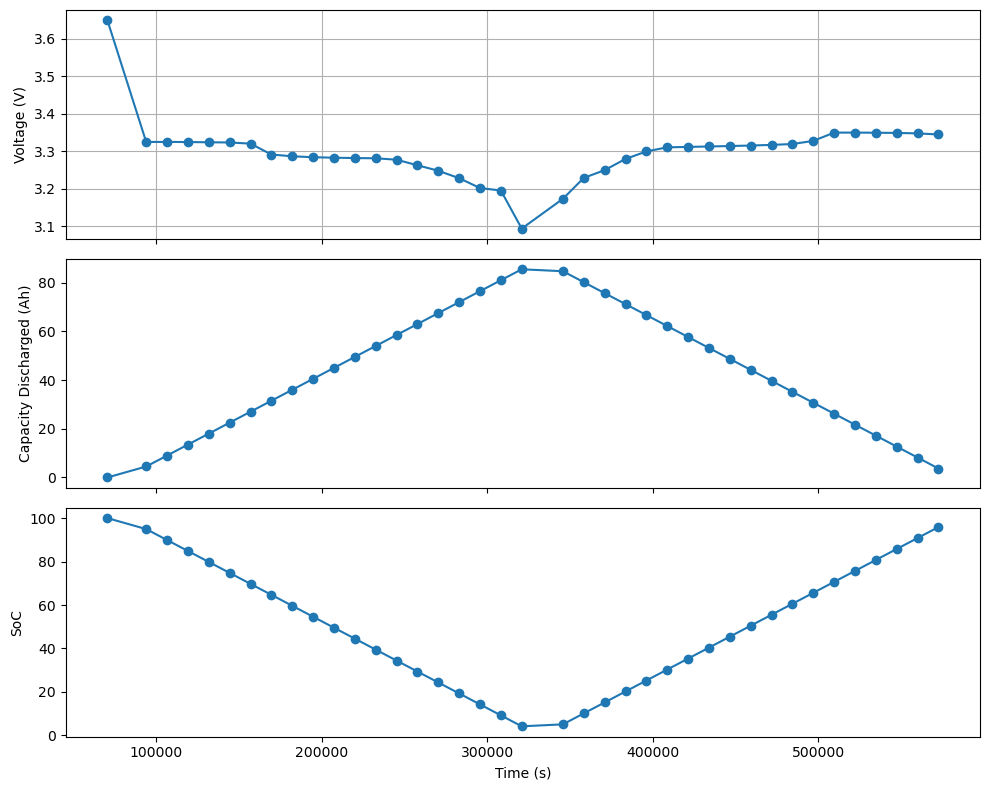

In [67]:
#A plot of the OCV values plus endpoints 

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(counter['time_s'], counter['voltage_V'], marker='o') 
axs[0].set_ylabel('Voltage (V)')
axs[0].grid(True)
axs[1].plot(counter['time_s'], counter['Ah_sum'], marker='o') 
axs[1].set_ylabel('Capacity Discharged (Ah)')
#axs[1].set_ylim(-10000, 10000) 
axs[2].plot(counter['time_s'], counter['SoC'], marker='o') 
axs[2].set_ylabel('SoC')
axs[2].set_xlabel('Time (s)') 
plt.tight_layout()
plt.show()

In [68]:
#Let's look at the voltage at the cycling points from from discharge/charge to rest
df['diff'] = df['Ns'].diff()
counter = df[df['diff'].shift(-1) == 1]
counter.head()

,time_s,voltage_V,I_mA,Capacity_mAh,dq_mAh,Energy_Wh,Temperature_degC,Ns,dt,diff
180,81518.359917,3.370905,0.000,0.000000,0.000000,0.000000,18.346330,0,60.034003,0.0
254,83318.358007,3.298137,-8998.533,4499.109088,-372.929850,14.844411,19.312557,1,149.202008,0.0
312,95918.394641,3.294670,-8998.139,4499.092347,-2276.397641,29.672348,19.581835,1,910.744046,0.0
376,108518.429274,3.291125,-8999.518,4499.108685,-2947.725951,44.486893,19.732311,1,1179.324059,0.0
449,121118.467908,3.286751,-8998.533,4499.103900,-271.764763,59.285992,19.550154,1,108.728005,0.0


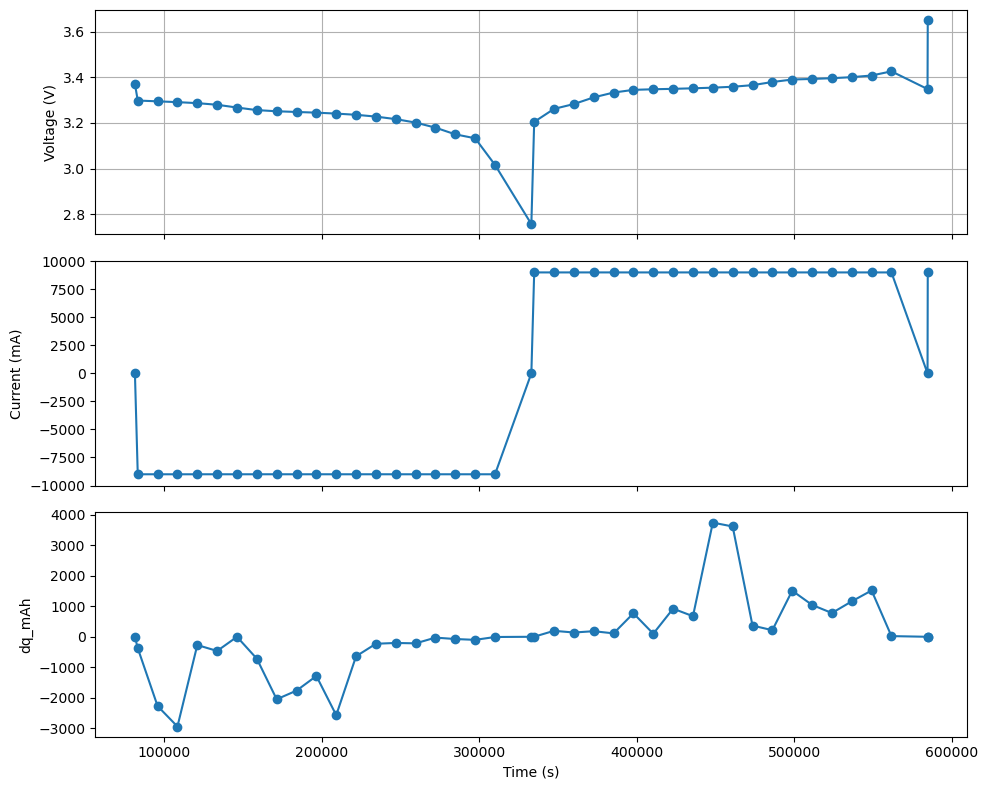

In [69]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(counter['time_s'], counter['voltage_V'], marker='o') 
axs[0].set_ylabel('Voltage (V)')
axs[0].grid(True)
axs[1].plot(counter['time_s'], counter['I_mA'], marker='o') 
axs[1].set_ylabel('Current (mA)')
axs[1].set_ylim(-10000, 10000) 
axs[2].plot(counter['time_s'], counter['dq_mAh'], marker='o') 
axs[2].set_ylabel('dq_mAh')
axs[2].set_xlabel('Time (s)') 
plt.tight_layout()
plt.show()

### Modelling

In [70]:
#import the characterization file 1
import os
os.getcwd()
dfv = pd.read_csv('_data/validation_profile.txt', delimiter='\t')
dfv = dfv.apply(pd.to_numeric, errors='coerce')

#check the headers
dfv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4012 entries, 0 to 4011
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time_s            4012 non-null   float64
 1   voltage_V         4012 non-null   float64
 2   I_mA              4012 non-null   float64
 3   Capacity_mAh      4012 non-null   float64
 4   dq_mAh            4012 non-null   float64
 5   Energy_Wh         4012 non-null   float64
 6   Temperature_degC  4012 non-null   float64
 7   Ns                4012 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 250.9 KB


In [71]:
dfv.describe()

,time_s,voltage_V,I_mA,Capacity_mAh,dq_mAh,Energy_Wh,Temperature_degC,Ns
count,4012.000000,4012.000000,4012.000000,4012.000000,4012.000000,4012.000000,4012.000000,4012.000000
mean,54110.335565,3.322178,-103.163581,914.844789,0.000605,13.878731,19.886741,6.069292
std,1124.217767,0.042610,19767.070802,1149.959828,5.244955,12.515143,0.810607,3.743947
min,52142.754477,3.216387,-44998.580000,0.000000,-12.498868,0.000000,18.674938,0.000000
25%,53137.632524,3.294405,0.000000,0.524963,0.000000,3.266782,19.185215,3.000000
50%,54124.816571,3.329890,0.000000,528.867007,0.000000,9.907669,19.730955,6.000000
75%,55084.564616,3.348292,0.000000,1461.715021,0.000000,24.740015,20.337770,9.000000
max,56042.954662,3.417558,45007.730000,3750.365787,12.501447,39.820532,22.205500,12.000000


In [72]:
(dfv['I_mA']/1000).describe()

count    4012.000000
mean       -0.103164
std        19.767071
min       -44.998580
25%         0.000000
50%         0.000000
75%         0.000000
max        45.007730
Name: I_mA, dtype: float64

In [73]:
dfv.head()

,time_s,voltage_V,I_mA,Capacity_mAh,dq_mAh,Energy_Wh,Temperature_degC,Ns
0,52142.754477,3.329930,0.0,0.0,0.0,0.0,19.005930,0
1,52143.754477,3.329969,0.0,0.0,0.0,0.0,19.037450,0
2,52144.754477,3.329811,0.0,0.0,0.0,0.0,19.116259,0
3,52145.754477,3.329851,0.0,0.0,0.0,0.0,18.919243,0
4,52146.754477,3.329890,0.0,0.0,0.0,0.0,19.021690,0


In [74]:
temp = dfv[dfv['Ns']==1]
temp.tail()

,time_s,voltage_V,I_mA,Capacity_mAh,dq_mAh,Energy_Wh,Temperature_degC,Ns
599,52738.870505,3.291609,-8993.997,739.797294,-2.498626,2.441332,20.282606,1
600,52739.870505,3.291570,-8996.163,742.295950,-2.498657,2.449556,20.266844,1
601,52740.870505,3.291491,-8995.770,744.794598,-2.498648,2.457781,20.306248,1
602,52741.870505,3.291452,-8997.346,747.293252,-2.498654,2.466005,20.392935,1
603,52742.788505,3.291452,-8994.392,749.587015,-2.293763,2.473555,20.227440,1


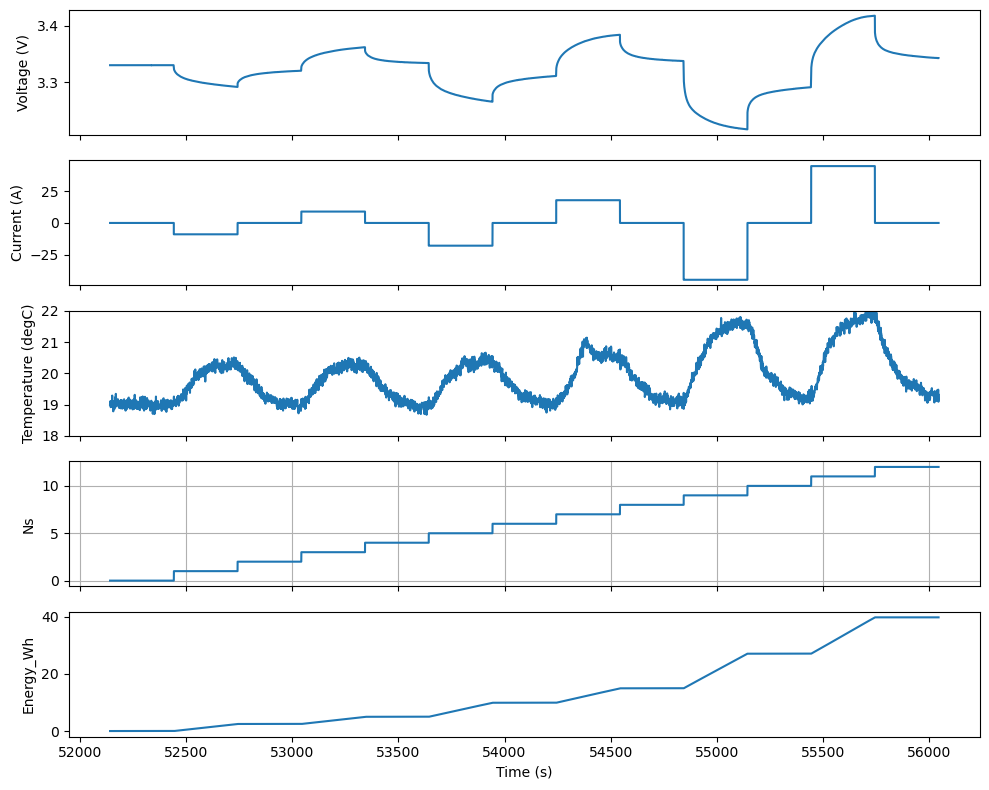

In [75]:
fig, axs = plt.subplots(5, 1, figsize=(10, 8), sharex=True)
axs[0].plot(dfv['time_s'], dfv['voltage_V']) 
axs[0].set_ylabel('Voltage (V)')
axs[1].plot(dfv['time_s'], dfv['I_mA']/1000) 
axs[1].set_ylabel('Current (A)')
#axs[1].set_ylim(-10000, 10000) 
axs[2].plot(dfv['time_s'], dfv['Temperature_degC']) 
axs[2].set_ylabel('Temperature (degC)')
axs[2].set_ylim(18,22)
axs[3].plot(dfv['time_s'], dfv['Ns'])
axs[3].set_ylabel('Ns')
#axs[3].set_ylim(0,10)
axs[3].grid('true')
axs[4].plot(dfv['time_s'], dfv['Energy_Wh'])
axs[4].set_ylabel('Energy_Wh')
axs[4].set_xlabel('Time (s)') 
#axs[4].set_xlim(70000, 650000) 

plt.tight_layout()
plt.show()


In [76]:
#copmare the ocv in the validation data set to the soc/ocv curve from the test data
#use the discharge phase of the data 
disch_soc = soc_ocv[0:19]
disch_soc

,voltage_V,Ah_sum,SoC
0,3.648819,-0.000000,100.000000
1,3.324337,4.499209,94.954930
2,3.324613,8.998401,89.909880
3,3.324140,13.497610,84.864811
4,3.323628,17.996814,79.819747
5,3.323037,22.496008,74.774694
6,3.319964,26.995216,69.729626
7,3.290927,31.494429,64.684552
8,3.286160,35.993653,59.639466
9,3.283757,40.492844,54.594417


In [77]:
def get_soc(voltage, df):
    i = df[df['voltage_V'] >= voltage].iloc[-1] #row where OCV curve has a greater voltage
    j = df[df['voltage_V'] <= voltage].iloc[0] #row where OCV curve has a lower voltage
    
    x2, y2 = i['voltage_V'], i['SoC']
    x1, y1 = j['voltage_V'], j['SoC']

    
    print('x1:y1 ', x1,' : ', y1)
    print('x2:y2 ', x2,' : ', y2)
    
    # Perform linear interpolation
    return y1 + (voltage - x1) * (y2 - y1) / (x2 - x1)

In [78]:
print('Calculated SoC: ', get_soc(3.329930, disch_soc).round(2), '%')

x1:y1  3.324337  :  94.9549304924625
x2:y2  3.648819  :  100.0
Calculated SoC:  95.04 %


In [79]:
start_i = 488
end_i = 533
socx = df[start_i+1:end_i].reset_index()
socx.head()

,index,time_s,voltage_V,I_mA,Capacity_mAh,dq_mAh,Energy_Wh,Temperature_degC,Ns,dt,diff
0,489,131918.504497,3.323431,-8998.5330,0.004999,-0.004999,59.286338,18.678967,1,0.002,-1.0
1,490,131918.560497,3.322328,-8997.5480,0.144977,-0.139978,59.286803,18.362171,1,0.056,0.0
2,491,131918.920497,3.321303,-8998.1390,1.044819,-0.899842,59.289792,18.465130,1,0.360,0.0
3,492,131919.514497,3.320279,-8998.9270,2.529558,-1.484738,59.294722,18.536410,1,0.594,0.0
4,493,131920.300497,3.319255,-8998.7295,4.494211,-1.964653,59.301245,18.583930,1,0.786,0.0


#### [2] Fit the 2-RC model 

In [80]:
# Fit a 2-RC Model on the test set and apply to the validation data set
#
#                            +---------------------+
#                            |                     |
#                V_oc -----> |      R0             |
#                            |                     |
#                            +---------------------+
#                                   |
#                                   I
#                                   |
#                          +--------+--------+
#                          |                 |
#                     +----|-----+       +---|-----+
#                     |    |     |       |   |     |
#                     |    R1    |       |   R2    |
#                     |    |     |       |   |     |
#                     |    C1    |       |   C2    |
#                     |    |     |       |   |     |
#                     +----+-----+       +---+-----+
#                          |                 |
#                          |                 |
#                          +-----------------+
#                                   |
#                                  GND


In [81]:
calculate_dcir(df, 281, 10)

OCV:  3.324337  V
start index:  281
closest index:  291
dt:  10.962000551167876  s
dV:  -0.009415999999999869  V
dI:  -8.998927  A
DCIR:  0.0010463469700331906 Ohm
DCIR:  1.046 mOhm


In [82]:
## this is the model fit letting A go negative 
## convention is -9A is a discharge current 

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Function to fit the 2-RC model
#pass in the I because it is constant 9A in the test data
#dcir values calculated prior to calling function fit
#call for a start/end 9A discharge pulse 
def fit_2rc_model_to_data(df, start_i, end_i, I, dcir_value):
    """
    Fit the 2-RC model to the battery data.

    df: DataFrame with time and voltage columns
    start_i: starting index of the data slice
    end_i: ending index of the data slice
    I: Discharge current (negative for discharge)
    dcir_value: DCIR value in milliohms (from measurement)

    Returns:
        Fitted parameters (OCV, A1, tau1, A2, tau2)
    """
    # Extract the time and voltage data within the given range
    socx = df[start_i + 1:end_i].reset_index(drop=True)  # Reset index after slicing
    time_s = socx['time_s'].values - socx['time_s'].values[0]  # Normalize time to start from 0
    voltage_V = socx['voltage_V'].values  # Measured voltage
    
    # Estimate OCV (Open Circuit Voltage) as the voltage at time=0
    #this is specific to these current pulses I am choosing the beginning from rest ast the first index
    OCV = voltage_V[0]  # Assume the first voltage value is OCV
    
    # DCIR and voltage drop due to internal resistance
    R0 = dcir_value / 1000  # Convert DCIR from mΩ to Ω
    V_drop = R0 * I  # Voltage drop due to internal resistance
    
    # Model with subtraction of IR drop
    #2-RC model to fit the voltage response of the battery.
    #from github - 
    #https://github.com/abhy-kumar/battery-modelling-project/blob/main/Battery_Modelling_project.ipynb
    #V_oc - I * R0 - I * R1 * (1 - np.exp(-t / (R1 * C1))) - I * R2 * (1 - np.exp(-t / (R2 * C2)))
    #rewritten A1=IR1, A2=IR2 tau1=R1C1 tau2=R2C2
    #V(t) = OCV + A1 * (1 - exp(-t / tau1)) + A2 * (1 - exp(-t / tau2))
    def rc2_model_adjusted(t, OCV, A1, tau1, A2, tau2):
        return OCV + A1 * (1 - np.exp(-t / tau1)) + A2 * (1 - np.exp(-t / tau2)) - V_drop

    # Initial guess for the parameters: OCV, A1, tau1, A2, tau2
    p0 = [OCV, 0.01, 4, 0.01, 100]  # tau1 short, tau2 long 10/300
    
    # Fit the model to the measured data
    popt, _ = curve_fit(rc2_model_adjusted, time_s, voltage_V, p0)
    
    # Extract fitted parameters
    OCV_fit, A1_fit, tau1_fit, A2_fit, tau2_fit = popt
    
    # Calculate the fitted voltage from the model
    v_fit = rc2_model_adjusted(time_s, *popt)
    
    # Plot measured voltage and the fitted 2-RC model
    plt.figure(figsize=(10, 6))
    plt.plot(time_s, voltage_V, label="Measured Voltage", color="green")
    plt.plot(time_s, v_fit, label="Fitted 2-RC Model", linestyle="--", color="blue")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    plt.title("2-RC Model Fit vs Measured Voltage")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return the fitted parameters
    return OCV_fit, A1_fit, tau1_fit, A2_fit, tau2_fit

# Function to back-calculate R and C from the fitted parameters (A1, A2, tau1, tau2)
def back_calculate_R_and_C(A1, A2, tau1, tau2, I):
    """
    Back-calculate the physical resistances (R1, R2) and capacitances (C1, C2) 
    from the fitted parameters (A1, A2, tau1, tau2) and the current I.
    A1=IR1, A2=IR2 tau1=R1C1 tau2=R2C2

    Parameters:
        A1, A2: Amplitudes for the two RC components
        tau1, tau2: Time constants for the two RC components
        I: Discharge current (in Amps)

    Returns:
        R1, C1, R2, C2: Resistors and Capacitors for the two RC components
    """
    # Back-calculate R1, C1
    #A1=IR1, A2=IR2 tau1=R1C1 tau2=R2C2
    R1 = A1 / I          # Resistance for the first RC component
    C1 = tau1 / R1       # Capacitance for the first RC component

    # Back-calculate R2, C2
    R2 = A2 / I          # Resistance for the second RC component
    C2 = tau2 / R2       # Capacitance for the second RC component

    # Return the calculated values
    return R1, C1, R2, C2



In [83]:
#95% pulse is 281 to 313 
#dcir30 = calculate_dcir(df, 281, 30)
calculate_dcir(df, 281, 10)
calculate_dcir(df, 281, 30)

OCV:  3.324337  V
start index:  281
closest index:  291
dt:  10.962000551167876  s
dV:  -0.009415999999999869  V
dI:  -8.998927  A
DCIR:  0.0010463469700331906 Ohm
DCIR:  1.046 mOhm
OCV:  3.324337  V
start index:  281
closest index:  297
dt:  30.994001558530726  s
dV:  -0.01560159999999966  V
dI:  -8.997745  A
DCIR:  0.0017339455608043639 Ohm
DCIR:  1.734 mOhm


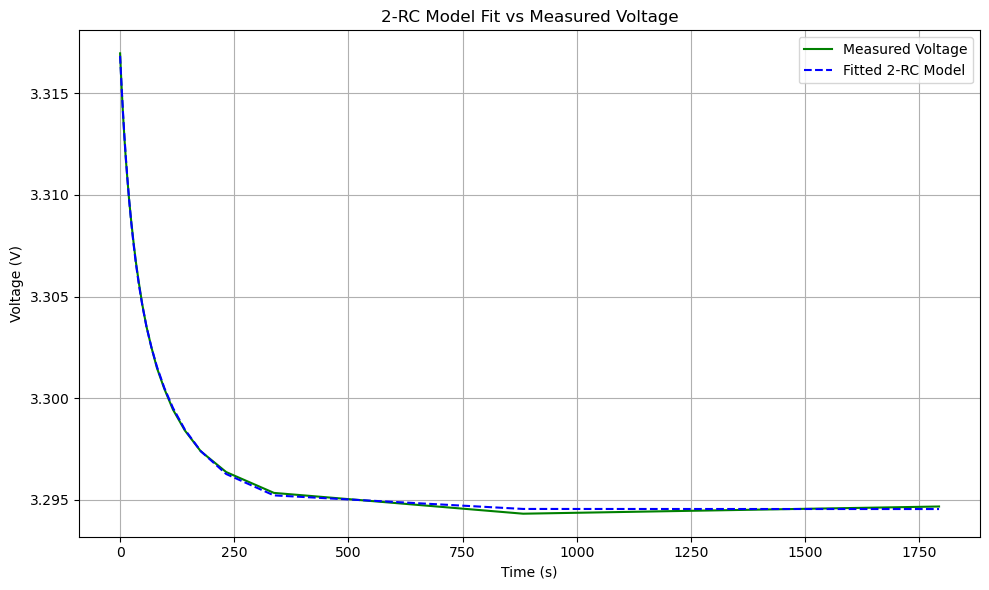

Fitted A1: -0.008339 V, Tau1: 23.10 s
Fitted A2: -0.013957 V, Tau2: 111.05 s

---- back calc ---- 

Back-calculated R1: 0.000927 Ω, C1: 24927.610267 F
Back-calculated R2: 0.001551 Ω, C2: 71606.277603 F


In [84]:
#95% SoC Fit the pulse is 288-313 index, dcir calc above
#use the dcir value of 10s here

#30 min pulse from index 288
start_i = 288  # Starting index 
end_i = 313    # Ending index 
dcir_value = 1.046 #10s
#dcir_value = 1.734  # 30s DCIR value mohm 
I = -9  # Discharge current (negative for discharge)

OCV_fit, A1_fit, tau1_fit, A2_fit, tau2_fit = fit_2rc_model_to_data(df, start_i, end_i, I, dcir_value)

# Print the fitted parameters
#print(f"Fitted OCV: {OCV_fit:.6f} V")
print(f"Fitted A1: {A1_fit:.6f} V, Tau1: {tau1_fit:.2f} s")
print(f"Fitted A2: {A2_fit:.6f} V, Tau2: {tau2_fit:.2f} s")

print('\n---- back calc ---- \n')
# Back-calculate the R and C values
R1, C1, R2, C2 = back_calculate_R_and_C(A1_fit, A2_fit, tau1_fit, tau2_fit, I)

# Print the back-calculated R and C values
print(f"Back-calculated R1: {R1:.6f} Ω, C1: {C1:.6f} F")
print(f"Back-calculated R2: {R2:.6f} Ω, C2: {C2:.6f} F")

In [85]:
calculate_dcir(df, 488, 10)
calculate_dcir(df, 488, 30)

OCV:  3.323628  V
start index:  488
closest index:  499
dt:  10.24000106845051  s
dV:  -0.010637599999999914  V
dI:  -8.998533  A
DCIR:  0.0011821482457195982 Ohm
DCIR:  1.182 mOhm
OCV:  3.323628  V
start index:  488
closest index:  506
dt:  29.26400305260904  s
dV:  -0.017886999999999986  V
dI:  -8.997941  A
DCIR:  0.001987899231613097 Ohm
DCIR:  1.988 mOhm


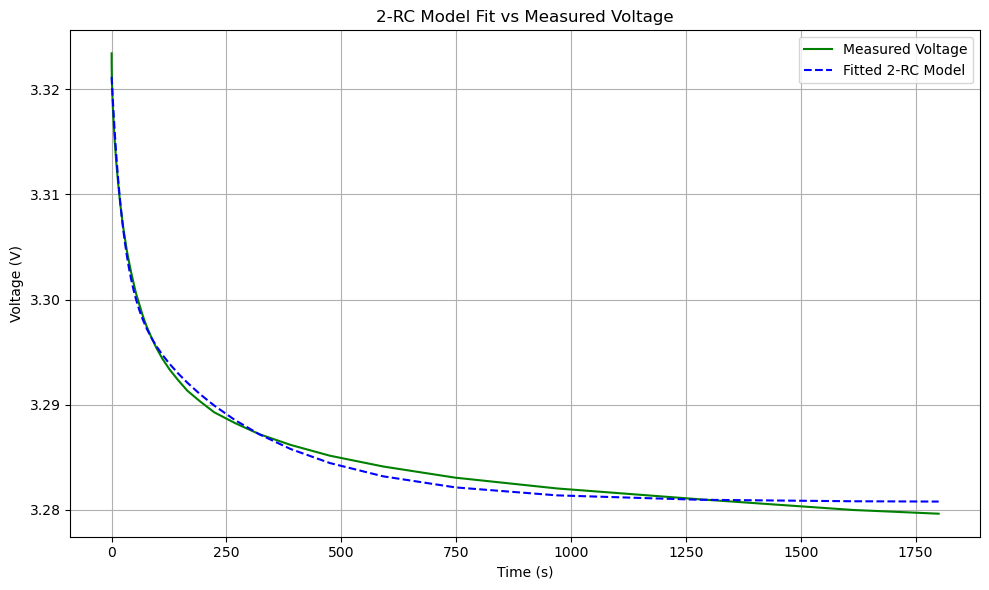

Fitted A1: -0.019941 V, Tau1: 24.79 s
Fitted A2: -0.020505 V, Tau2: 277.29 s

---- back calc ---- 

Back-calculated R1: 0.002216 Ω, C1: 11188.060784 F
Back-calculated R2: 0.002278 Ω, C2: 121706.411606 F


In [86]:
#80% SOC Fit 
#use 10s dcir in the presented results

#30 min pulse from index 488
start_i = 488  # Starting index 
end_i = 533    # Ending index 
dcir_value = 1.182 #10s dcir value #1.988  # 30s DCIR value mohm 
I = -9  # Discharge current (negative for discharge)

OCV_fit, A1_fit, tau1_fit, A2_fit, tau2_fit = fit_2rc_model_to_data(df, start_i, end_i, I, dcir_value)

# Print the fitted parameters
#print(f"Fitted OCV: {OCV_fit:.6f} V")
print(f"Fitted A1: {A1_fit:.6f} V, Tau1: {tau1_fit:.2f} s")
print(f"Fitted A2: {A2_fit:.6f} V, Tau2: {tau2_fit:.2f} s")

print('\n---- back calc ---- \n')
# Back-calculate the R and C values
R1, C1, R2, C2 = back_calculate_R_and_C(A1_fit, A2_fit, tau1_fit, tau2_fit, I)

# Print the back-calculated R and C values
print(f"Back-calculated R1: {R1:.6f} Ω, C1: {C1:.6f} F")
print(f"Back-calculated R2: {R2:.6f} Ω, C2: {C2:.6f} F")


In [87]:
calculate_dcir(df, 579, 10)
calculate_dcir(df, 579, 30)

OCV:  3.323037  V
start index:  579
closest index:  590
dt:  9.776001019869  s
dV:  -0.010676999999999826  V
dI:  -8.997941  A
DCIR:  0.0011866048021430486 Ohm
DCIR:  1.187 mOhm
OCV:  3.323037  V
start index:  579
closest index:  598
dt:  30.550003186799586  s
dV:  -0.018911199999999795  V
dI:  -8.998336  A
DCIR:  0.0021016330130370544 Ohm
DCIR:  2.102 mOhm


/var/folders/89/gvrgzhw96d1dtvdbkt0fp3jr0000gn/T/ipykernel_38546/3088825775.py:47: RuntimeWarning: overflow encountered in exp
  return OCV + A1 * (1 - np.exp(-t / tau1)) + A2 * (1 - np.exp(-t / tau2)) - V_drop


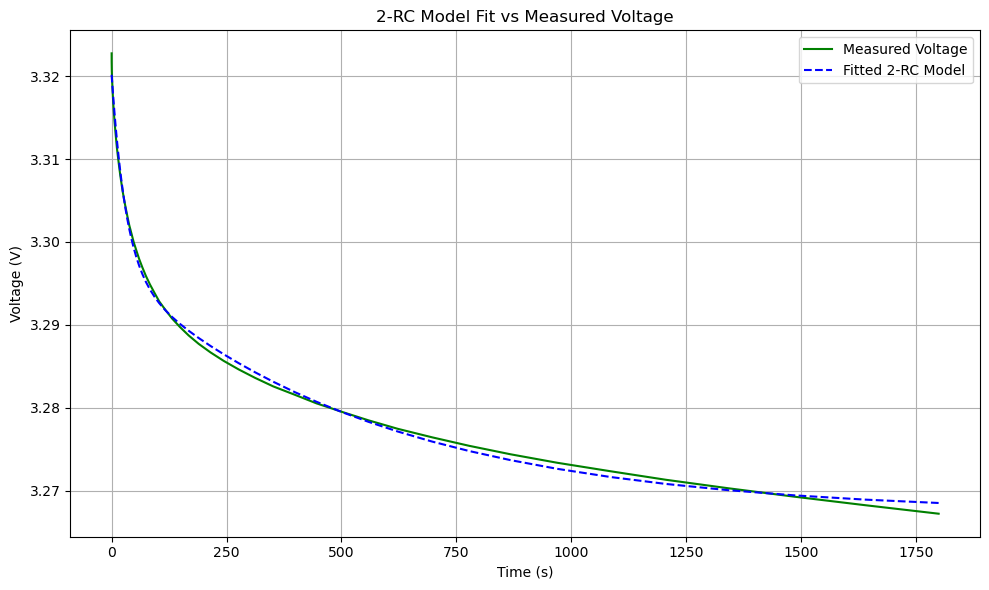

Fitted A1: -0.023501 V, Tau1: 30.97 s
Fitted A2: -0.029426 V, Tau2: 570.51 s

---- back calc ---- 

Back-calculated R1: 0.002611 Ω, C1: 11860.598062 F
Back-calculated R2: 0.003270 Ω, C2: 174489.887836 F


In [88]:
#75% SoC, dcir is 2.1mOhm index of pulse is 579 to 635

#30 min pulse from index 579
#socx = df[579:635]
start_i = 579  # Starting index 
end_i = 635    # Ending index 
dcir_value = 1.187  # 10s DCIR value mohm 
I = -9  # Discharge current (negative for discharge)

OCV_fit, A1_fit, tau1_fit, A2_fit, tau2_fit = fit_2rc_model_to_data(df, start_i, end_i, I, dcir_value)

# Print the fitted parameters
#print(f"Fitted OCV: {OCV_fit:.6f} V")
print(f"Fitted A1: {A1_fit:.6f} V, Tau1: {tau1_fit:.2f} s")
print(f"Fitted A2: {A2_fit:.6f} V, Tau2: {tau2_fit:.2f} s")

print('\n---- back calc ---- \n')
# Back-calculate the R and C values
R1, C1, R2, C2 = back_calculate_R_and_C(A1_fit, A2_fit, tau1_fit, tau2_fit, I)

# Print the back-calculated R and C values
print(f"Back-calculated R1: {R1:.6f} Ω, C1: {C1:.6f} F")
print(f"Back-calculated R2: {R2:.6f} Ω, C2: {C2:.6f} F")

#### [3] Validate the 2-RC model 

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [90]:
#import the characterization file 1
import os
os.getcwd()
dfv = pd.read_csv('_data/validation_profile.txt', delimiter='\t')
dfv = dfv.apply(pd.to_numeric, errors='coerce')

In [91]:
#dfv['time_s'] = dfv['time_s'] - dfv['time_s'].iloc[0]
dfv.head()

,time_s,voltage_V,I_mA,Capacity_mAh,dq_mAh,Energy_Wh,Temperature_degC,Ns
0,52142.754477,3.329930,0.0,0.0,0.0,0.0,19.005930,0
1,52143.754477,3.329969,0.0,0.0,0.0,0.0,19.037450,0
2,52144.754477,3.329811,0.0,0.0,0.0,0.0,19.116259,0
3,52145.754477,3.329851,0.0,0.0,0.0,0.0,18.919243,0
4,52146.754477,3.329890,0.0,0.0,0.0,0.0,19.021690,0


In [92]:
#Derivation for the simulation update function

# I_R = V1 / R1
# I_C = C1 * dV1/dt

# Total current entering the RC branch:
#   I = I_R + I_C
#   I  = V1 / R1 + C1 * dV1/dt

# Rearrange to solve for dV1/dt:
# C1 dV1/dt = I - V1/R1
# dV1/dt = I/C1 - V1/(R1 C1)
# dV1/dt = I/C1 - V1/(R1 C1) = IR1/(R1 C1) - V1/(R1 C1) = (IR1 - V1) / (R1 C1) = (V1 - I*R1 )/ tau

# Now divide both sides by C1:
#   dV1/dt = ( -V1 + I R1 ) / (R1 * C1)

# Let tau1 = R1 * C1 (the RC time constant), then:

# Final ODE:
#  dV1/dt = ( -V1(t) + I(t) * R1 ) / tau1 				    #ODE for the RC

# V1(t + dt) ≈ V1(t) + (dV1/dt) * dt 					     # Euler method
# V1(t + dt) = V1(t) + [(-V1(t) + I(t) * R1) / tau1] * dt.   # substitute the expression derived above from ODE
# V1(t + dt) = V1(t) + (-V1(t) + I(t) * R1) * dt / tau1
# V1(t + dt) = V1 + (-V1 + I * R1 ) * dt / tau1
# dV = (-V1 + I * R1 ) * dt / tau1
# V1 += dV

0.0009265555555555555


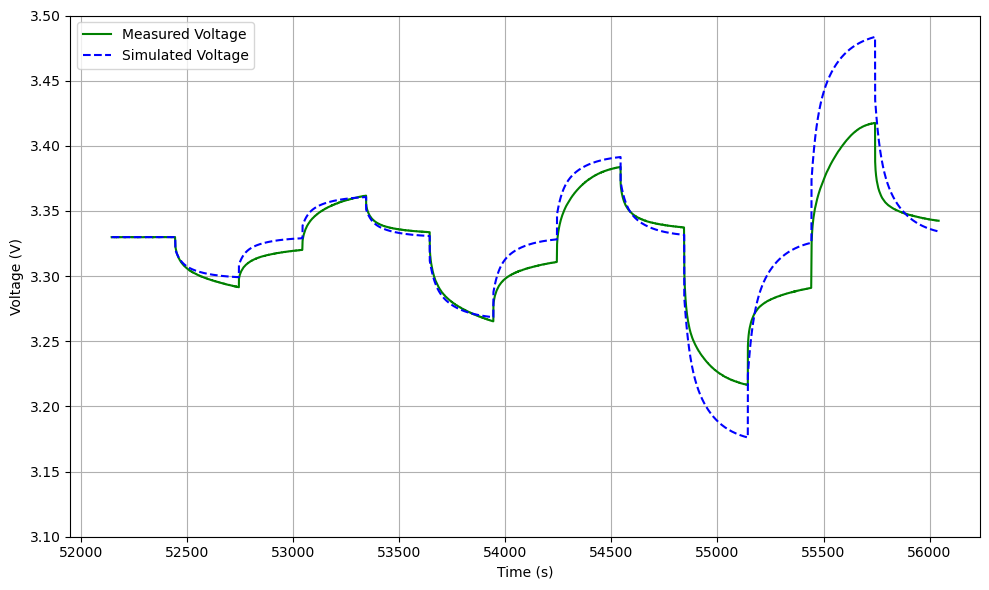

RMSE: 0.0236 V
MAE: 0.0148 V


In [93]:
### This is the result in the presentation ####
### Uses uses an -A sign convention and euler method ###
### Alternatively us +A and +I for discharge
### It has the Recalculate R1 and R2 from fit parameters A to avoid a current scaling problem ####

def simulate_2rc_voltage(dfv, A1, tau1, A2, tau2, R0):
    # Convert time and current
    time = dfv['time_s'].values
    current_A = dfv['I_mA'].values / 1000  # mA → A
    dt = np.diff(time, prepend=time[0] - 1e-3)

    # OCV assumed constant (or could be dfv['voltage_V'].iloc[0])
    OCV = dfv['voltage_V'].iloc[0]

    # Recalculate R1 and R2 from fit parameters
    I_fit = -9.0  # Amps used during fitting
    R1 = A1 / I_fit
    R2 = A2 / I_fit
    print(R1)

    # Initialize RC voltages
    V1 = 0.0
    V2 = 0.0
    voltage_sim = []


    # Euler integration loop
    for i in range(len(time)):
        I = current_A[i]
        
        dV1 = (-V1 - I * R1) * dt[i] / tau1
        dV2 = (-V2 - I * R2) * dt[i] / tau2
        V1 += dV1
        V2 += dV2
        #print('dV1: ', dV1 , 'dV2: ', dV2, 'V1: ', V1 ,'V2: ', V2)
        V_total = OCV - V1 - V2 + I * R0
        voltage_sim.append(V_total)

    return np.array(voltage_sim)

# 95% SoC fit parameteres


#Fitted A1: -0.008339 V, Tau1: 23.10 s
#Fitted A2: -0.013957 V, Tau2: 111.05 s

A1 = -0.008339
tau1 = 23.10
A2 = -0.013957
tau2 = 111.05
R0 = 1.046/1000  # DCIR in ohms

#dfv = dfv[280:400].copy()
# Call the function
simulated_voltage = simulate_2rc_voltage(dfv, A1=A1, tau1=tau1, A2=A2, tau2=tau2, R0=R0)

# Simulated vs Measured
plt.figure(figsize=(10, 6))
plt.plot(dfv['time_s'], dfv['voltage_V'], label="Measured Voltage", color="green")
plt.plot(dfv['time_s'], simulated_voltage, label="Simulated Voltage", linestyle="--", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.ylim(3.1,3.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Compute error metrics
rmse = np.sqrt(mean_squared_error(dfv['voltage_V'], simulated_voltage))
mae = mean_absolute_error(dfv['voltage_V'], simulated_voltage)

# Print the results
print(f"RMSE: {rmse:.4f} V")
print(f"MAE: {mae:.4f} V")

0.0009265555555555555
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.3299296 dV1:  -0.0 dV2:  -0.0 V1:  0.0 V2:  0.0
V_total:  3.329929

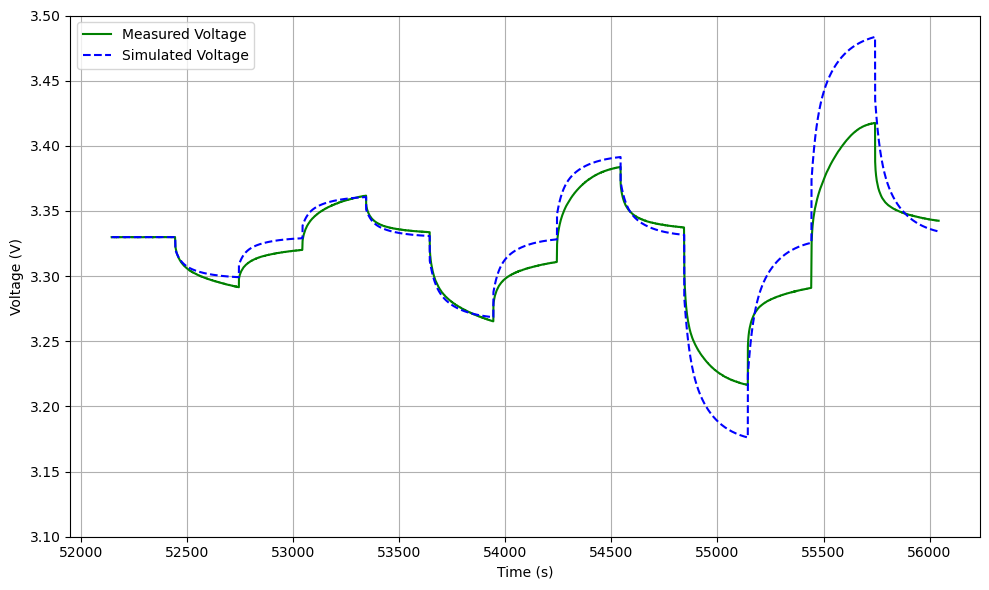

RMSE: 0.0236 V
MAE: 0.0148 V


In [94]:
#print statements and check signs and change to I postive for discharge 
# the equations are more intuitive with a positive current for discharge as the convention

### This is the result in the presentation ####
### Uses the -A sign convention and euler method ###
### It has the Recalculate R1 and R2 from fit parameters to avoid the current scaling problem ####

def simulate_2rc_voltage(dfv, A1, tau1, A2, tau2, R0):
    # Convert time and current
    time = dfv['time_s'].values
    current_A = dfv['I_mA'].values / 1000  # mA → A
    dt = np.diff(time, prepend=time[0] - 1e-3)

    # OCV assumed constant (or could be dfv['voltage_V'].iloc[0])
    OCV = dfv['voltage_V'].iloc[0]

    # Recalculate R1 and R2 from fit parameters
    I_fit = -9.0  # Amps used during fitting
    R1 = A1 / I_fit
    R2 = A2 / I_fit
    print(R1)

    # Initialize RC voltages
    V1 = 0.0
    V2 = 0.0
    voltage_sim = []


    # Euler integration loop
    for i in range(len(time)):
        I = -current_A[i] #discharge is positive
        
        dV1 = (-V1 + I * R1) * dt[i] / tau1
        dV2 = (-V2 + I * R2) * dt[i] / tau2
        V1 += dV1
        V2 += dV2
        
        V_total = OCV - V1 - V2 - I * R0

        print('V_total: ', V_total, 'dV1: ', dV1 , 'dV2: ', dV2, 'V1: ', V1 ,'V2: ', V2)
        
        voltage_sim.append(V_total)

    return np.array(voltage_sim)

# 95% SoC fit parameteres


#Fitted A1: -0.008339 V, Tau1: 23.10 s
#Fitted A2: -0.013957 V, Tau2: 111.05 s

A1 = -0.008339
tau1 = 23.10
A2 = -0.013957
tau2 = 111.05
R0 = 1.046/1000  # DCIR in ohms

#dfv = dfv[280:400].copy()
# Call the function
simulated_voltage = simulate_2rc_voltage(dfv, A1=A1, tau1=tau1, A2=A2, tau2=tau2, R0=R0)

# Simulated vs Measured
plt.figure(figsize=(10, 6))
plt.plot(dfv['time_s'], dfv['voltage_V'], label="Measured Voltage", color="green")
plt.plot(dfv['time_s'], simulated_voltage, label="Simulated Voltage", linestyle="--", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.ylim(3.1,3.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Compute error metrics
rmse = np.sqrt(mean_squared_error(dfv['voltage_V'], simulated_voltage))
mae = mean_absolute_error(dfv['voltage_V'], simulated_voltage)

# Print the results
print(f"RMSE: {rmse:.4f} V")
print(f"MAE: {mae:.4f} V")